# Customer Review Analysis of Amazon Smartphone Products Using Named Entity Recognition, Topic Modelling, and Sentiment Analysis: A Stimulus–Organism–Response Perspective 

This notebook implements sentiment analysis, topic modelling, and named entity recognition (NER) on Amazon smartphone reviews to extract actionable business insights.  
The analysis is structured using the Stimulus–Organism–Response (S-O-R) framework to connect customer experiences, emotions, and behavioural outcomes.

Online customer reviews strongly influence purchase decisions, especially for high-involvement products such as smartphones.
Star ratings give a brief overall score, but they do not show the specific reasons customers report satisfaction or dissatisfaction.This project applies Natural Language Processing (NLP) techniques to extract emotional signals from review text, identify recurring customer experience themes, link dissatisfaction to specific operational touchpoints. The objective is to move beyond descriptive metrics and support data-driven managerial decision-making.

In [1]:
# Install required Python packages quietly (-q = less output)
!pip -q install pandas numpy matplotlib scikit-learn bertopic sentence-transformers umap-learn hdbscan vaderSentiment spacy tqdm
# Download the small English NLP model for spaCy
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Environment Setup and libraries
This section installs and imports the packages used for Data handling, Visualisation, Sentiment analysis, Topic modelling, Named Entity Recognition 

In [2]:
import re                          # Regular expressions for text cleaning
import numpy as np                 # Numerical operations
import pandas as pd                # DataFrames and CSV handling
from tqdm import tqdm              # progress bar utility
tqdm.pandas()                      # enable .progress_apply() for pandas


import matplotlib.pyplot as plt     # plotting charts

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer           # VADER sentiment tool
from bertopic import BERTopic                                                  # Topic modelling library
import spacy                                                                   # NLP library for Named Entity Recognition


print("Setup complete ")


Setup complete 


## 2. Data Loading 
 The dataset, Amazon Reviews: Unlocked Mobile Phones is loaded from a CSV file, prints the dimension of data and display the column names. This notebook builds a pipeline to convert review text into measurable insights.


In [51]:
#Load dataset
DATA_PATH = "Amazon_Unlocked_Mobile.csv"
df = pd.read_csv(DATA_PATH)                                             # Read CSV into a DataFrame

print("Rows, Columns:", df.shape)                                      # Print dataset size (rows, columns)
print("Columns:", list(df.columns))
df.head()  


Rows, Columns: (413840, 6)
Columns: ['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews', 'Review Votes']


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


 ## 3.Variable Selection

The dataset is filtered to keep only variables necessary for the analysis


In [52]:
#Keep only relevant columns
keep = ["Product Name", "Brand Name", "Price", "Rating", "Reviews", "Review Votes"]            # columns of interest
keep = [c for c in keep if c in df.columns]                        # keep only columns that actually exist in file
df = df[keep].copy()                                               # subset DataFrame and copy to avoid chained warnings

df.head()                                                          # preview updated DataFrame


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


## 4. Data Preparation & Cleaning 
Review texts are cleaned to remove missing reviews to ensures analysis reflects real customer experience, duplicate reviews to avoids repeated content biasing the insight, Clean URLs and punctuation to reduces irrelevant tokens, remove very short reviews to improves topic clarity

In [53]:
#Clean reviews (text preprocessing)
review_col = "Reviews"               # name of column that contains review text
rating_col = "Rating"                # name of column that contains star rating

# Drop rows with missing review text or rating
df = df.dropna(subset=[review_col, rating_col]).copy()
# Convert review column to string 
df[review_col] = df[review_col].astype(str)
# Remove duplicate reviews 
df = df.drop_duplicates(subset=[review_col]).copy()

def clean_text(text: str) -> str:
    text = text.lower()                                # Convert to lowercase
    text = re.sub(r"http\S+|www\.\S+", " ", text)      # remove URLs
    text = re.sub(r"[^a-z0-9\s']", " ", text)          # remove special characters (keep letters/numbers/apostrophes)
    text = re.sub(r"\s+", " ", text).strip()           # normalize whitespaces
    return text
    
# Apply cleaning function to each review (with progress bar)
df["clean_review"] = df[review_col].progress_apply(clean_text)

# Remove very short reviews (improves topic clarity)
df = df[df["clean_review"].str.len() >= 20].copy()

print("After cleaning:", df.shape)              # print new dataset size after cleaning
df[["clean_review", rating_col]].head()         # preview cleaned review text + rating


100%|██████████| 162490/162490 [00:07<00:00, 21609.53it/s]


After cleaning: (151120, 7)


,clean_review,Rating
0,i feel so lucky to have found this used phone ...,5
1,nice phone nice up grade from my pantach revue...,4
3,it works good but it goes slow sometimes but i...,4
4,great phone to replace my lost phone the only ...,4
5,i already had a phone with problems i know it ...,1


##  5.Descriptive Statistics

An overview of star rating distribution and most frequently reviewed brands. These descriptive statistics contextualise later sentiment and topic findings.


In [54]:
#Basic dataset summaries
print("Rating distribution:")
print(df[rating_col].value_counts().sort_index())       # count reviews per rating (1–5)

print("\nTop brands by review volume:")
print(df["Brand Name"].value_counts().head(10))         # top 10 brands by number of reviews


Rating distribution:
Rating
1    31535
2    11091
3    13767
4    24248
5    70479
Name: count, dtype: int64

Top brands by review volume:
Brand Name
Samsung       28176
BLU           15395
Apple         12141
LG            11532
Nokia          8107
HTC            7465
BlackBerry     7159
Motorola       6655
OtterBox       4751
Sony           3260
Name: count, dtype: int64


## 6.Sentiment Analysis (VADER)

This section applies VADER sentiment analysis to all cleaned reviews to calculate compound sentiment score and then classify those reviews to positive, neutral, or negative using standard thresholds. Sentiment results are stored as numerical scores and categorical labels.


In [55]:
#Sentiment Analysis (VADER)
#Run VADER sentiment on the full dataset
analyzer = SentimentIntensityAnalyzer()   # initialize VADER sentiment analyzer

texts = df["clean_review"].astype(str).tolist()     # convert cleaned reviews to list of strings

# Compute compound sentiment score for each review (-1 = very negative, +1 = very positive)
df["sentiment_score"] = [analyzer.polarity_scores(t)["compound"] for t in texts]

s = df["sentiment_score"].to_numpy()                #convert sentiment scores to NumPy array for fast operations

# Assign sentiment label using VADER thresholds
df["sentiment_label"] = np.where(s > 0.05, "positive",
                          np.where(s < -0.05, "negative", "neutral"))

df["sentiment_label"].value_counts()            # show counts of positive/negative/neutral


sentiment_label
positive    104497
negative     32674
neutral      13949
Name: count, dtype: int64

## 7. Validating Sentiment Against Star Ratings
This section cross-tabulates sentiment labels against star ratings. To assess whether sentiment polarity aligns with numeric ratings and the consistency and validity of sentiment classification the output is normalised.


In [56]:
#Sentiment label distribution across ratings
# Crosstab:for each star rating, show proportion of sentiment labels (row-normalized)
pd.crosstab(df[rating_col], df["sentiment_label"], normalize="index")

sentiment_label,negative,neutral,positive
Rating,,,
1,0.590392,0.171460,0.238148
2,0.460644,0.155712,0.383644
3,0.306748,0.123338,0.569914
4,0.102400,0.061160,0.836440
5,0.031797,0.051561,0.916642


## 8. Overall Sentiment Distribution

The overall distribution of sentiment labels across all reviews is vizualised here. The plot provides a high-level view of the emotional landscape of customer feedback.


In [78]:
import os
os.makedirs("figures", exist_ok=True)


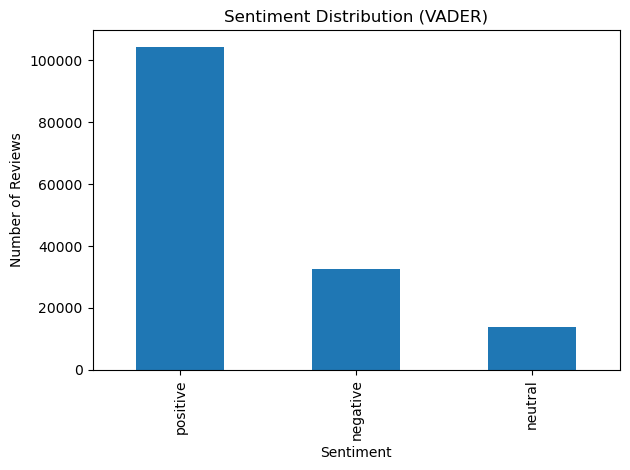

In [79]:
#Overall Sentiment Distribution plot
df["sentiment_label"].value_counts().plot(kind="bar")   # bar chart of sentiment counts
plt.title("Sentiment Distribution (VADER)")             # title
plt.xlabel("Sentiment")                                 # X-axis label
plt.ylabel("Number of Reviews")                         # Y-axis label
plt.tight_layout()                                      # layout

plt.savefig("figures/sentiment_distribution.png", dpi=300, bbox_inches="tight")

plt.show()                                              # display plot


## 9. Sentiment Distribution Across Ratings

The heatmap visualises the share of positive, neutral, and negative sentiment within each star rating category. It is used to validate sentiment results and identify nuanced emotional patterns, especially in mid-range ratings.


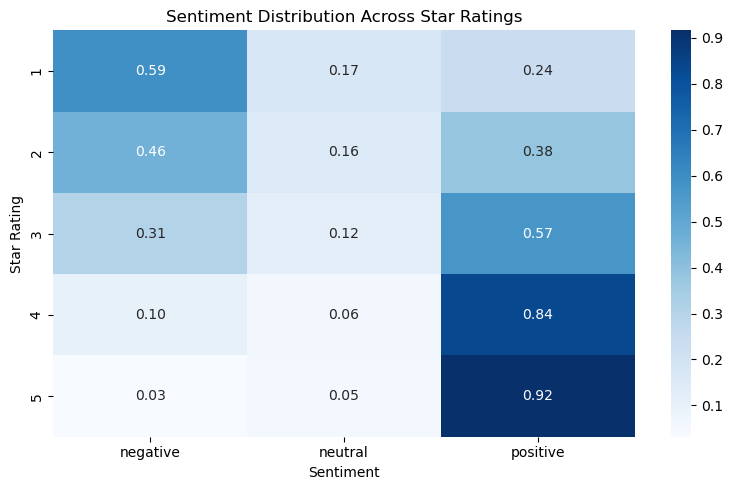

In [80]:
#Sentiment vs Rating Heatmap
import seaborn as sns          # heatmap plotting library

plt.figure(figsize=(8, 5))     # set figure size
sns.heatmap(
    pd.crosstab(df["Rating"], df["sentiment_label"], normalize="index"),           # normalized row proportions
    annot=True, fmt=".2f", cmap="Blues"                                            # show values with 2 decimals
)
plt.title("Sentiment Distribution Across Star Ratings")    # plot title
plt.xlabel("Sentiment")                                    # X-axis label
plt.ylabel("Star Rating")                                  # Y-axis label
plt.tight_layout()                                         # layout adjustment
plt.savefig("figures/sentiment_vs_rating_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()                                                 # display heatmap


## 10. Topic Modelling (Stimulus in S-O-R)
Topic modelling identifies what customers repeatedly talk about (themes).
Since dataset is large and BERTopic can be computationally heavy, we train on a random sample of reviews to reduce computational cost and to preserve topic diversity. Each review in the training sample is assigned a topic ID.



In [59]:
#Topic Modelling (Stimulus in S-O-R)
TRAIN_SIZE = 50000                                                         # sample size for training topics
df_train = df.sample(min(TRAIN_SIZE, len(df)), random_state=42).copy()     # random sample for training
docs_train = df_train["clean_review"].tolist()                             # training documents as list

topic_model = BERTopic(language="english", verbose=True)       # create BERTopic model
train_topics, _ = topic_model.fit_transform(docs_train)        # fit model, assign topics to training docs

df_train["topic"] = train_topics                               # store topic assignments for training sample
topic_model.get_topic_info().head(15)                          # view first 15 topics summary


2026-01-17 21:04:34,405 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2026-01-17 21:34:23,571 - BERTopic - Embedding - Completed ✓
2026-01-17 21:34:23,571 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-17 21:35:30,765 - BERTopic - Dimensionality - Completed ✓
2026-01-17 21:35:30,859 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-17 21:36:28,937 - BERTopic - Cluster - Completed ✓
2026-01-17 21:36:29,047 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-17 21:36:32,452 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,23026,-1_the_and_to_phone,"[the, and, to, phone, it, is, this, for, that,...",[i have to say that this phone is an excellent...
1,0,1040,0_hear_speaker_volume_sound,"[hear, speaker, volume, sound, microphone, lou...",[works well my only problem is that it is hard...
2,1,790,1_el_de_que_en,"[el, de, que, en, la, lo, es, muy, con, excele...",[realmente es un tel fono muy til y divertido ...
3,2,700,2_shipping_delivery_fast_arrived,"[shipping, delivery, fast, arrived, shipped, d...","[great phone fast shipping, great phone fast s..."
4,3,614,3_blu_studio_vivo_phones,"[blu, studio, vivo, phones, life, xl, hd, of, ...",[i was looking for an upgrade phone from my ip...
5,4,565,4_blackberry_bb_keyboard_classic,"[blackberry, bb, keyboard, classic, bold, q10,...",[i've had this phone for about 3 months now an...
6,5,547,5_memory_sd_storage_internal,"[memory, sd, storage, internal, gb, card, spac...",[better than an iphone you can find lots of ap...
7,6,416,6_iphone_4s_apple_5s,"[iphone, 4s, apple, 5s, 5c, an, condition, new...",[it says it a iphone 4s on the description but...
8,7,407,7_sim_card_sims_slot,"[sim, card, sims, slot, tray, cards, micro, na...","[there is no sim card, did not have a sim card..."
9,8,396,8_4g_lte_3g_2g,"[4g, lte, 3g, 2g, 850, 900, bands, mobile, net...",[this not working on 4g i have one and not wor...


## 11. Topic Reduction to 12 Themes 
Raw topic models often produce many granular topics.
For that we reduce to 12 themes to keep the results interpretable, communicable, aligned to typical smartphone decision areas (battery, condition, compatibility, service, etc.)


In [60]:
#Reduce topics to 12 themes
NR_TOPICS = 12                                                            # target number of themes
topic_model = topic_model.reduce_topics(docs_train, nr_topics=NR_TOPICS)  # merge similar topics into 12

topic_info = topic_model.get_topic_info()                                 # updated topic summary table
topic_info.head(15)


2026-01-17 21:41:12,086 - BERTopic - Topic reduction - Reducing number of topics
2026-01-17 21:41:12,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-17 21:41:16,046 - BERTopic - Representation - Completed ✓
2026-01-17 21:41:16,061 - BERTopic - Topic reduction - Reduced number of topics from 363 to 12


,Topic,Count,Name,Representation,Representative_Docs
0,-1,23026,-1_the_and_it_phone,"[the, and, it, phone, to, is, this, for, of, w...",[i have to say that this phone is an excellent...
1,0,22094,0_the_phone_and_it,"[the, phone, and, it, to, is, this, for, not, of]",[here's where i'm coming from nokia lumia 920 ...
2,1,2452,1_product_good_it_excellent,"[product, good, it, excellent, great, very, fo...",[the product is excellent the service very goo...
3,2,997,2_battery_it_not_charge,"[battery, it, not, charge, the, and, to, work,...",[the product is very good i have bought two pr...
4,3,795,3_case_the_otterbox_it,"[case, the, otterbox, it, my, and, for, to, th...","[its a great case i love it, i love this case ..."
5,4,340,4_expected_what_thanks_expectations,"[expected, what, thanks, expectations, exactly...","[it was exactly what i expected, it was exactl..."
6,5,132,5_fits_fit_it_small,"[fits, fit, it, small, smaller, great, for, an...","[perfect fit looks great love it, did not fit ..."
7,6,52,6_wifi_not_internet_connect,"[wifi, not, internet, connect, the, to, work, ...","[the wifi its not working, the wifi was not wo..."
8,7,40,7_dirty_black_color_purple,"[dirty, black, color, purple, it, gets, lamb, ...",[love lovelove it i had a white one and it got...
9,8,33,8_excelent_product_good_goog,"[excelent, product, good, goog, assistance, th...","[excelent product its great, excelent good pro..."


## 12. Topic Assignment to Full Dataset

The trained topic model is applied to the full dataset.


In [61]:
#Apply topic model to full dataset
docs_full = df["clean_review"].tolist()            # full dataset documents
full_topics, _ = topic_model.transform(docs_full)  # assign topic labels to every review

df["topic"] = full_topics                          # save topic labels into main DataFrame
df["topic"].value_counts().head(10)                # show most frequent topics


Batches:   0%|          | 0/4723 [00:00<?, ?it/s]

2026-01-17 23:04:07,125 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2026-01-17 23:06:16,594 - BERTopic - Dimensionality - Completed ✓
2026-01-17 23:06:16,594 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2026-01-17 23:06:40,875 - BERTopic - Cluster - Completed ✓


topic
-1    82722
 0    56502
 1     6151
 2     2366
 3     1766
 4      889
 5      345
 6      129
 8      100
 7       73
Name: count, dtype: int64

In [62]:
#Build topic sentiment summary table
df_use = df[df["topic"] != -1].copy()       # remove outliers topic (-1)

topic_sentiment = (
    df_use.groupby("topic", as_index=False)            # group by topic id
    .agg(
        review_count=("sentiment_score", "size"),      # number of reviews in topic
        avg_sentiment=("sentiment_score", "mean"),      # mean sentiment score
        avg_rating=("Rating", "mean"),                   # mean star rating
        negative_pct=("sentiment_label", lambda x: (x=="negative").mean()*100),      # % negative
        positive_pct=("sentiment_label", lambda x: (x=="positive").mean()*100),      # % positive
    )
)


## 13. Clean Topic Keywords and Theme Labels
To improve topic interpretability, generic and domain-common words are removed from topic keywords, human-readable theme labels are assigned, themes are linked to exemplar customer reviews This is done to address credibility and interpretability concerns in topic modelling outputs.


In [63]:
#Clean topic keywords (removing the generic words)
extra_stopwords = {                                                   # extra stopwords to filter from topic keywords
    "the","and","to","it","is","was","are","for","this","that",
    "phone","phones","amazon","product","one","get","got","use",
    "good","great","just","like"
}

def clean_topic_keywords(topic_id, topn=8):
    if topic_id == -1:
        return "Outliers"                                       # label for outlier topic
    words = topic_model.get_topic(topic_id)                     # get topic words with weights
    cleaned = [w for w, _ in words if w not in extra_stopwords] # remove generic words
    return ", ".join(cleaned[:topn])                            # return top N cleaned words

# Create a cleaned keyword string per topic for reporting
topic_sentiment["clean_keywords"] = topic_sentiment["topic"].apply(
    lambda t: clean_topic_keywords(t, 8)
)


In [64]:
def get_examples(topic_id, n=2, max_len=180):
    examples = df[df["topic"] == topic_id]["Reviews"].sample(               # sample example reviews belonging to a given topic
        n=min(n, (df["topic"] == topic_id).sum()),                          # avoid sampling more than available
        random_state=42,                                                    # reproducibility
        replace=True                                                        # allow replacement if topic is small
    ).tolist()
    return [e[:max_len] for e in examples]                                  # truncate text for readability

# Store 2 example snippets for each topic
topic_sentiment["example_1"] = topic_sentiment["topic"].apply(
    lambda t: get_examples(t, 2)[0]
)
topic_sentiment["example_2"] = topic_sentiment["topic"].apply(
    lambda t: get_examples(t, 2)[1]
)


In [65]:
#Consolidated theme labels mapping
theme_labels = {                                 # manually mapping topic_id 
    0: "Battery performance & charging",
    1: "Device condition & refurbishment quality",
    2: "Network compatibility & unlocking",
    3: "Customer service, returns & refunds",
    4: "Screen/display & build quality",
    5: "Performance, lag & overheating",
    6: "Camera quality & image performance",
    7: "Delivery, packaging & logistics",
    8: "Accessories & charging equipment",
    9: "Software issues & updates",
    10: "Value for money",
    11: "General usability & setup"
}
 
topic_sentiment["theme_label"] = topic_sentiment["topic"].map(theme_labels)         # add label column
topic_sentiment = topic_sentiment.sort_values("review_count", ascending=False)      # sort by topic size


## 14. Topic-Level Visualisations
These plots illustrate the most frequently discussed themes, themes with highest negative sentiment and average star ratings by theme. Together, they highlight which aspects of the customer experience require prioritisation.



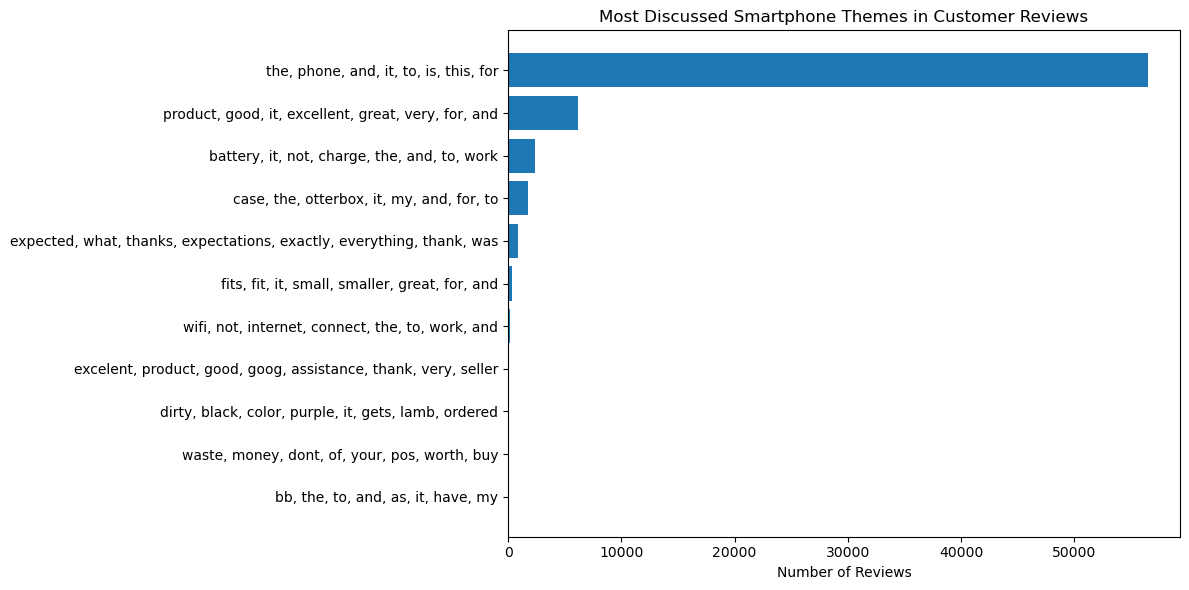

In [81]:
#Plot top themes by frequency
top_n = 12                    # number of themes to plot
plot_df = topic_sentiment.head(top_n).sort_values("review_count")           # take top N, then sort for barh plot

plt.figure(figsize=(12,6))                                        # figure size
plt.barh(plot_df["theme_label"], plot_df["review_count"])         # horizontal bar chart
plt.title("Most Discussed Smartphone Themes in Customer Reviews") # title
plt.xlabel("Number of Reviews")                                   # X-label
plt.tight_layout()                                                # layout adjustment
plt.savefig("figures/most_discussed_themes.png", dpi=300, bbox_inches="tight")

plt.show()


In [67]:
#print topic words and sample reviews
def topic_keywords(t, topn=10):
    if t == -1:
        return "Outliers"
    words = topic_model.get_topic(t)                             # get topic words
    return ", ".join([w for w, _ in words[:topn]]) if words else "N/A"   # return top keywords

topics = sorted([t for t in df["topic"].unique() if t != -1])      # get topic ids except outliers

for t in topics:
    print(f"\nTopic {t}: {topic_keywords(t, 10)}")                  # print topic keywords
    examples = df[df["topic"] == t].sample(2, random_state=42, replace=True)["Reviews"].tolist()   # Sample 2 reviews
    for e in examples:
        print("-", e[:200], "...")                                    # print a short snippet
 


Topic 0: the, phone, and, it, to, is, this, for, not, of
- Nice phone, very clean, but too old for the current Verizon technology, so I can't get a contract to use. ...
- Great phone, camera is awesome. ...

Topic 1: product, good, it, excellent, great, very, for, and, condition, works
- Excellent product . A plus seller. ...
- Excellent condition super happy with the device and whoever great team and very helpful ...

Topic 2: battery, it, not, charge, the, and, to, work, working, after
- the battery doesn't work..... I dit a bad purshare ...
- Broken in under 30 days ...

Topic 3: case, the, otterbox, it, my, and, for, to, this, is
- My Mother Baptized her cell phone, only to find out it was a Methodist. So, long story short, I bought this case for her new phone and it fits like it should. She loved the colors and the fit. She kee ...
- This will not fit my child's iPhone 5. Pushes on the volume on the side when in case. 😔 ...

Topic 4: expected, what, thanks, expectations, exactly,

In [68]:
#Recomputing topic sentiment summary
df_use = df[df["topic"] != -1].copy()                       # exclude outliers

topic_sentiment = (df_use.groupby("topic", as_index=False)    
    .agg(
        review_count=("sentiment_score", "size"),             # reviews per topic
        avg_sentiment=("sentiment_score", "mean"),            # mean sentiment
        avg_rating=(rating_col, "mean"),                      # mean rating
        negative_pct=("sentiment_label", lambda x: (x=="negative").mean()*100),   # % negative
        positive_pct=("sentiment_label", lambda x: (x=="positive").mean()*100),   # % positive
    )
)

topic_sentiment["theme_label"] = topic_sentiment["topic"].apply(lambda t: topic_keywords(t, 8))    # label using keywords
topic_sentiment = topic_sentiment.sort_values("review_count", ascending=False).reset_index(drop=True)  # sort & reset index

topic_sentiment.head(15)


,topic,review_count,avg_sentiment,avg_rating,negative_pct,positive_pct,theme_label
0,0,56502,0.335540,3.488744,23.643411,65.457860,"the, phone, and, it, to, is, this, for"
1,1,6151,0.609483,4.692408,2.780036,91.237197,"product, good, it, excellent, great, very, for..."
2,2,2366,-0.040181,2.311919,44.632291,30.473373,"battery, it, not, charge, the, and, to, work"
3,3,1766,0.494309,4.154020,14.496036,79.898075,"case, the, otterbox, it, my, and, for, to"
4,4,889,0.354790,4.537683,3.487064,62.654668,"expected, what, thanks, expectations, exactly,..."
5,5,345,0.422290,3.921739,11.304348,70.724638,"fits, fit, it, small, smaller, great, for, and"
6,6,129,-0.118605,1.844961,43.410853,21.705426,"wifi, not, internet, connect, the, to, work, and"
7,8,100,0.300844,4.880000,0.000000,59.000000,"excelent, product, good, goog, assistance, tha..."
8,7,73,0.026568,2.904110,31.506849,38.356164,"dirty, black, color, purple, it, gets, lamb, o..."
9,10,40,-0.132392,1.300000,55.000000,37.500000,"waste, money, dont, of, your, pos, worth, buy"


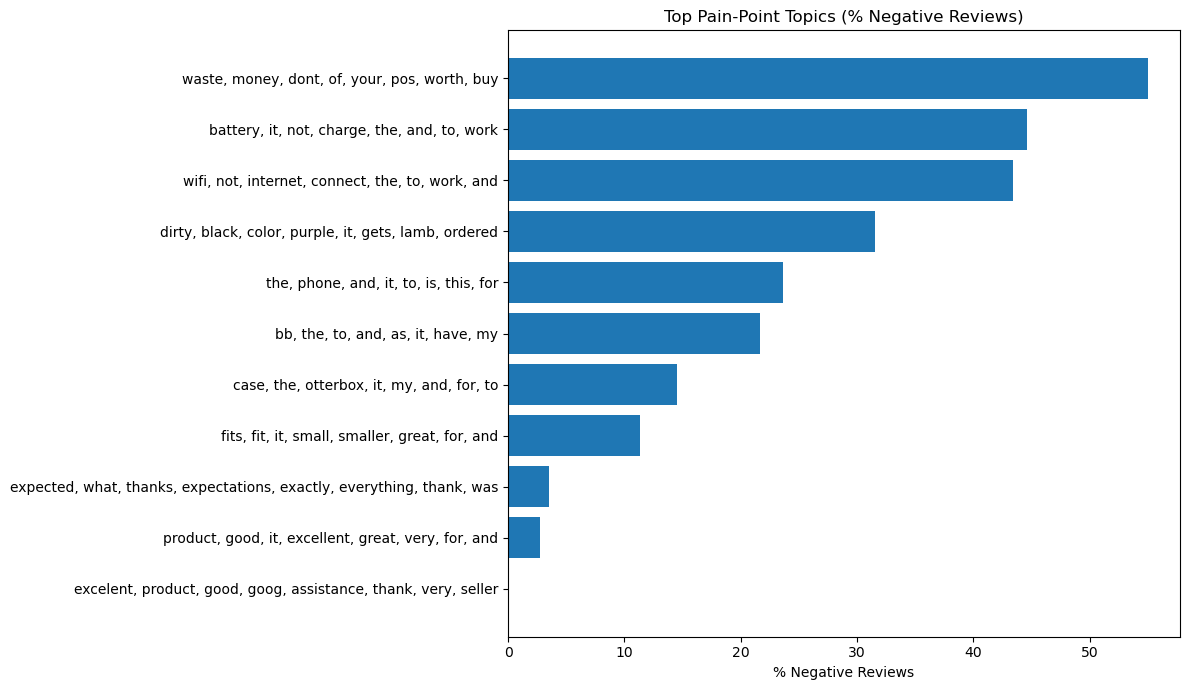

In [82]:
#Plot top pain-point topics (% negative)
top_n = 12              # top N by negative %
plot_data = topic_sentiment.sort_values("negative_pct", ascending=False).head(top_n).copy()          # sort for a good horizontal plot
plot_data = plot_data.sort_values("negative_pct")

plt.figure(figsize=(12, 7))          # figure Size
plt.barh(plot_data["theme_label"], plot_data["negative_pct"])    # plot
plt.title("Top Pain-Point Topics (% Negative Reviews)")         # title
plt.xlabel("% Negative Reviews")                               # X-label
plt.tight_layout()                                             # layout
plt.savefig("figures/top_pain_points.png", dpi=300, bbox_inches="tight")
plt.show()


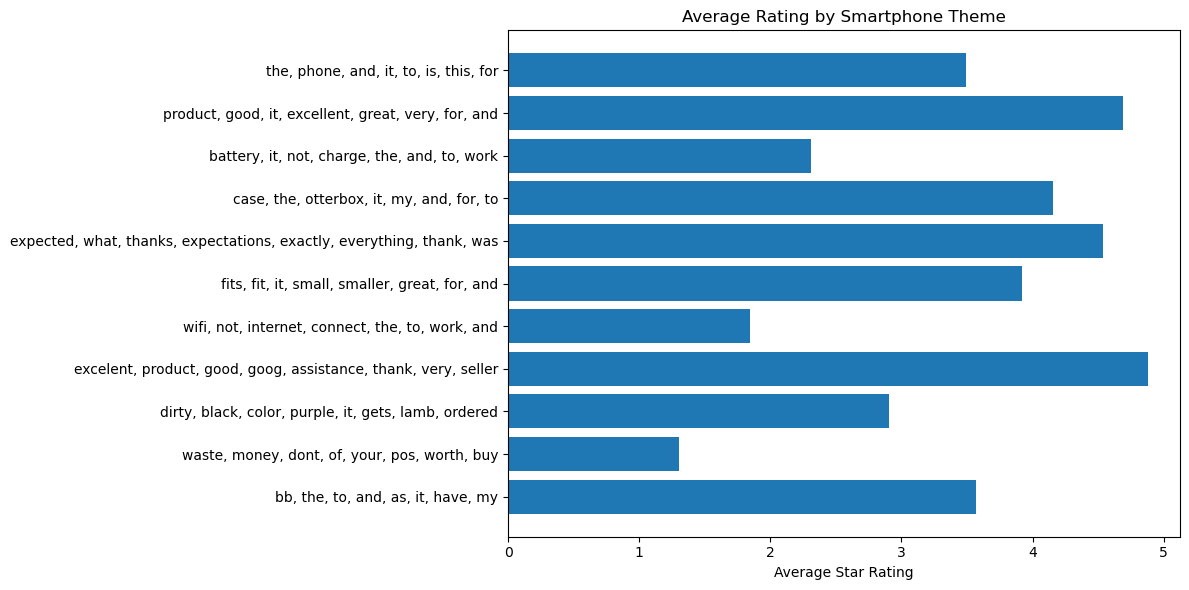

In [70]:
# Topic × Average Rating (using consolidated theme labels)

top_n = 12
top_topics = topic_sentiment.head(top_n).copy()            # select top themes

plt.figure(figsize=(12, 6))
plt.barh(top_topics["theme_label"], top_topics["avg_rating"])         # plot avg rating
plt.gca().invert_yaxis()                                              # placing highest at top
plt.title("Average Rating by Smartphone Theme")
plt.xlabel("Average Star Rating")
plt.tight_layout()
plt.show()



## 15. Named Entity Recognition 
Topic models tell us the theme, but not who or what is involved. SpaCy’s NER model is applied to negative reviews only. Entities such as organisations, products, and locations are extracted to identify operational touchpoints associated with dissatisfaction.

In [71]:
#Named Entity Recognition extraction from negative reviews
nlp = spacy.load("en_core_web_sm")                     # load spaCy model

df_ner = df[df["sentiment_label"] == "negative"].sample(
    min(15000, (df["sentiment_label"] == "negative").sum()),             # sample up to 15k negative reviews
    random_state=42
).copy()

def extract_entities(text):
    doc = nlp(str(text))                                                # run spaCy NER 
    return [(ent.text, ent.label_) for ent in doc.ents]            # return (entity text, entity type)

df_ner["entities"] = df_ner["Reviews"].progress_apply(extract_entities)      # extract entities with progress bar
df_ner.head()


100%|██████████| 15000/15000 [04:59<00:00, 50.16it/s]


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,clean_review,sentiment_score,sentiment_label,topic,entities
403288,Universal Mini Bluetooth Headset Wireless Hand...,inDigi,9.99,1,It has a terrible echo.,0.0,it has a terrible echo,-0.4767,negative,0,[]
40500,Apple iPhone 5s 16GB (Silver) - Verizon Wireless,Apple,149.99,1,I bought this phone at the end of May. By the ...,NaN,i bought this phone at the end of may by the e...,-0.4190,negative,-1,"[(the end of May, DATE), (the end of July, DAT..."
222138,LG G3 LG-F400 Quad HD IPS 32GB Shine Gold Fact...,LG,639.00,1,I don not like LG G3 because it is corian vers...,0.0,i don not like lg g3 because it is corian vers...,-0.6136,negative,0,"[(LG G3, ORG)]"
78591,Apple Smart Watch Sport 38mm - Stainless Steel...,Apple,269.99,1,Watch was missing from package,2.0,watch was missing from package,-0.2960,negative,0,[]
95199,BlackBerry Curve 9300 3G Unlocked GSM Smartpho...,BlackBerry,59.99,4,"Excelente producto, recomendado 100%, buena at...",0.0,excelente producto recomendado 100 buena atenc...,-0.6844,negative,0,"[(100%, PERCENT), (buena, ORG), (del vendedor,..."


## 16. Filter NER Non-Entities
This block removes non-informative entities such as numbers, dates, quantities. Only meaningful entity types (ORG, PRODUCT, GPE) are kept so that the resulting plot highlights frequently mentioned brands and service providers in negative reviews.


In [72]:
# Filtering NER
from collections import Counter             # count items 
    
KEEP_LABELS = {"ORG", "PRODUCT", "GPE"}        # keep only meaningful entities
DROP_LABELS = {"CARDINAL", "ORDINAL", "DATE", "TIME", "QUANTITY", "PERCENT", "MONEY"} # remove noisy entities

def is_noise(text):
    return re.fullmatch(r"\d+", str(text)) is not None         # returns True if entity is only digits

def filter_entities(ents):
    return [
        (t, l) for t, l in ents
        if l in KEEP_LABELS and l not in DROP_LABELS and not is_noise(t)  # keep only non-noisy entities
    ]

df_ner["entities_clean"] = df_ner["entities"].apply(filter_entities)  # apply filtering

all_entities = []                 #store all filtered entities
for ents in df_ner["entities_clean"]:
    all_entities.extend(ents)

entity_counts = Counter(all_entities).most_common(15)    # append each entity list

entity_df = pd.DataFrame(
    [(e, l, c) for (e, l), c in entity_counts],
    columns=["Entity", "Type", "Count"]
)

entity_df       #display the table




,Entity,Type,Count
0,Amazon,ORG,694
1,Samsung,ORG,469
2,AT&T,ORG,450
3,SIM,ORG,393
4,US,GPE,291
5,Android,ORG,240
6,BLU,ORG,184
7,Sony,ORG,183
8,Apple,ORG,177
9,Nokia,ORG,162


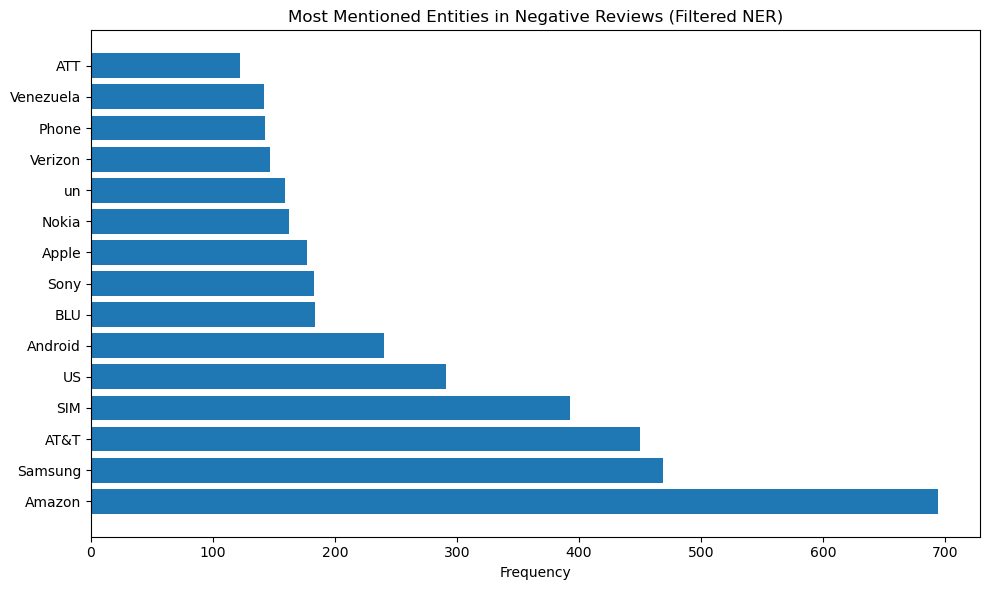

In [83]:
#Top Entities in Negative Reviews
from collections import Counter

all_entities = []
for ents in df_ner["entities_clean"]:
    all_entities.extend(ents)                 # flatten list of lists

entity_counts = Counter(all_entities).most_common(15)    # top 15 entities

entity_df = pd.DataFrame(
    [(e, l, c) for (e, l), c in entity_counts],
    columns=["Entity", "Type", "Count"]
)

plt.figure(figsize=(10,6))
plt.barh(entity_df["Entity"], entity_df["Count"])                  # horizontal bar plot
plt.title("Most Mentioned Entities in Negative Reviews (Filtered NER)")  # title
plt.xlabel("Frequency")                                                  # X-label
plt.tight_layout()                                                       # layout
plt.savefig("figures/ner_filtered_entities.png", dpi=300, bbox_inches="tight")
plt.show()


In [84]:
import os
os.listdir("figures")

['most_discussed_themes.png',
 'ner_filtered_entities.png',
 'sentiment_distribution.png',
 'sentiment_vs_rating_heatmap.png',
 'top_pain_points.png']

In [85]:
import os
os.makedirs("data", exist_ok=True)

In [87]:
df.sample(5000, random_state=42).to_csv("sample_reviews.csv", index=False)
print("Saved : sample_reviews.csv")

Saved : sample_reviews.csv


## 17. Exporting Outputs 
All key analytical outputs are saved to CSV files, including full dataset with sentiment and topics, topic summary table, filtered NER entities. These files are used in the dissertation results chapter, appendices.

In [75]:
# saving outputs to CSV 
import os
os.makedirs("outputs", exist_ok=True)                                      # create output folder

df.to_csv("outputs/full_dataset_with_sentiment_topics.csv", index=False)   # save full dataset with sentiment & topic
topic_info.to_csv("outputs/topic_info.csv", index=False)                   # save topic info
topic_sentiment.to_csv("outputs/topic_sentiment_table.csv", index=False)   # save topic summary table
entity_df.to_csv("outputs/ner_entities_filtered.csv", index=False)         # save filtered NER entity table

print("All outputs saved")


All outputs saved
